## Prerequisites

In [12]:
from datasets import keepcontrol
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from utils.losses import MyWeigtedSparseCategoricalCrossentropy

In [13]:
# Global variables
PATH = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata" if sys.platform == "linux" else "Z:\\Keep Control\\Data\\lab dataset\\rawdata"
DEMOGRAPHICS_FILE = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata/participants.tsv" if sys.platform == "linux" else "Z:\\Keep Control\\Data\\lab dataset\\rawdata\\participants.tsv"
TRACKED_POINTS = ["left_ankle", "right_ankle"]
CLASSIFICATION_TASK = "events"
WIN_LEN = 400

## Get the data

In [14]:
ds_train, ds_val, ds_test = keepcontrol.load_data(
    path=PATH,
    filename=DEMOGRAPHICS_FILE,
    tracked_points=TRACKED_POINTS,
    incl_magn=False,
    classification_task=CLASSIFICATION_TASK,
    win_len=WIN_LEN
)

Load dataset from pickle ...


In [15]:
# Split datasets in data and labels
(train_data, train_labels, train_filenames, train_ids) = ds_train
(val_data, val_labels, val_filenames, val_ids) = ds_val

In [16]:
# Shape: (batch_size, win_len, num_channels)
print(f"Shape of train data: {train_data.shape}")
print(f"Shape of train labels: {train_labels.shape}")
print(f"Shape of val data: {val_data.shape}")
print(f"Shape of val labels: {val_labels.shape}")

Shape of train data: (3472, 400, 6)
Shape of train labels: (3472, 400, 2)
Shape of val data: (714, 400, 6)
Shape of val labels: (714, 400, 2)


Convert the labels to sparse categorical arrays.

In [17]:
train_targets = np.zeros((train_labels.shape[0], train_labels.shape[1], 1), dtype=int)
for m in range(train_labels.shape[-1]):
    indx = np.argwhere(train_labels[:,:,m]==1)
    for i in range(indx.shape[0]):
        train_targets[indx[i][0]][indx[i][1],0] = m+1

val_targets = np.zeros((val_labels.shape[0], val_labels.shape[1], 1), dtype=int)
for m in range(val_labels.shape[-1]):
    indx = np.argwhere(val_labels[:,:,m]==1)
    for i in range(indx.shape[0]):
        val_targets[indx[i][0]][indx[i][1],0] = m+1

## Explore the data

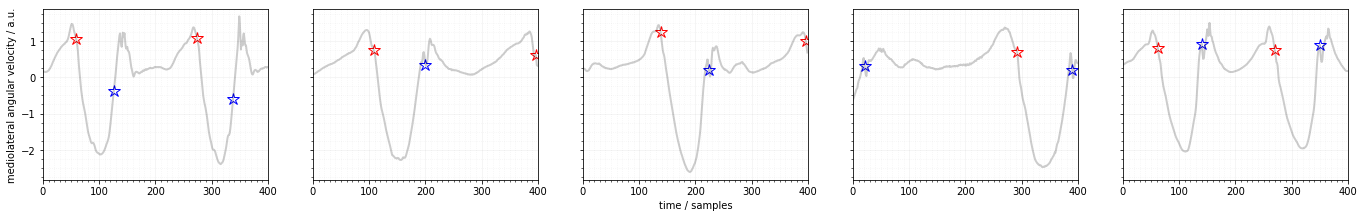

In [18]:
num_examples = 5
indx_random = np.random.choice(train_data.shape[0], num_examples, replace=False)
cm = 1/2.54
fig, axs = plt.subplots(1, num_examples, figsize=(2*29.7*cm, 8*cm), sharey=True)
for (i, indx) in enumerate(indx_random):
    if CLASSIFICATION_TASK == "events":
        axs[i].plot(np.argwhere(train_targets[indx][:,0]==2)[:,0], train_data[indx][np.argwhere(train_targets[indx][:,0]==2)[:,0],5], ls="none", marker="*", mfc="none", mec="r", ms=12)
        axs[i].plot(np.argwhere(train_targets[indx][:,0]==1)[:,0], train_data[indx][np.argwhere(train_targets[indx][:,0]==1)[:,0],5], ls="none", marker="*", mfc="none", mec="b", ms=12)
    else:
        axs[i].fill_between(np.arange(train_labels[indx].shape[0]), train_labels[indx][:,0]*max(train_data[indx][:,5]), color=(0, 1, 0), alpha=0.1, edgecolor='none')
        axs[i].fill_between(np.arange(train_labels[indx].shape[0]), train_labels[indx][:,0]*min(train_data[indx][:,5]), color=(0, 1, 0), alpha=0.1, edgecolor='none')
    axs[i].plot(train_data[indx][:,5], color=(0, 0, 0), alpha=0.2, lw=2)
    axs[i].xaxis.set_minor_locator(plt.MultipleLocator(10))
    axs[i].yaxis.set_minor_locator(plt.MultipleLocator(0.25))
    axs[i].grid(True, which="minor", ls=":", color=(0, 0, 0), alpha=0.05)
    axs[i].grid(True, which="major", color=(0, 0, 0), alpha=0.05)
    axs[i].set_xlim((0, train_data[indx].shape[0]))
axs[0].set_ylabel("mediolateral angular velocity / a.u.")
axs[num_examples//2].set_xlabel("time / samples")
plt.show()

## Build model

In [19]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense
from tcn import TCN, tcn_full_summary

In [23]:
def make_model(input_shape, classification_task="events"):
    
    # Define the layers that make up the architecture
    input_layer = Input(shape=(None, input_shape[-1]), name="input_layer")
    tcn_layer = TCN(padding="same", return_sequences=True, use_skip_connections=True, use_batch_norm=True, name="tcn_layer")(input_layer)
    if classification_task == "events":
        output_layer = Dense(units=3, activation="softmax", name="output_layer")(tcn_layer)
    else:
        output_layer = Dense(units=1, activation="sigmoid", name="output_layer")(tcn_layer)
    
    # Define the model
    tcn_model = Model(inputs=input_layer, outputs=output_layer, name="tcn_model")
    
    # Compile the model
    tcn_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    return tcn_model

In [24]:
tcn_model = make_model(train_data.shape[1:], classification_task=CLASSIFICATION_TASK)
tcn_model.summary()

Model: "tcn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, None, 6)]         0         
                                                                 
 tcn_layer (TCN)             (None, None, 64)          140608    
                                                                 
 output_layer (Dense)        (None, None, 3)           195       
                                                                 
Total params: 140,803
Trainable params: 139,267
Non-trainable params: 1,536
_________________________________________________________________


In [26]:
train_targets.shape

(3472, 400, 1)

In [30]:
weights = np.random.uniform(size=train_targets.shape)
weights.shape

(3472, 400, 1)

In [47]:
weights = np.zeros_like(train_targets)
print(weights.shape)

weights[train_targets>0] = 1.0
print(weights.shape)

(3472, 400, 1)
(3472, 400, 1)


In [48]:
history = tcn_model.fit(
    x=train_data,
    y=train_targets,
    epochs=5,
    batch_size=32,
    validation_data=(val_data, val_targets),
    shuffle=True,
    sample_weight=weights
)

Epoch 1/5
109/109 [==============================] - 16s 121ms/step - loss: 0.0040 - categorical_accuracy: 0.8695 - val_loss: 0.5424 - val_categorical_accuracy: 0.8598
Epoch 2/5
109/109 [==============================] - 13s 120ms/step - loss: 0.0014 - categorical_accuracy: 0.8098 - val_loss: 0.6597 - val_categorical_accuracy: 0.8360
Epoch 3/5
109/109 [==============================] - 13s 120ms/step - loss: 8.6630e-04 - categorical_accuracy: 0.7700 - val_loss: 0.8394 - val_categorical_accuracy: 0.7951
Epoch 4/5
109/109 [==============================] - 13s 120ms/step - loss: 5.8807e-04 - categorical_accuracy: 0.7293 - val_loss: 1.0148 - val_categorical_accuracy: 0.7478
Epoch 5/5
109/109 [==============================] - 13s 118ms/step - loss: 4.1976e-04 - categorical_accuracy: 0.6984 - val_loss: 1.1345 - val_categorical_accuracy: 0.7152


In [49]:
history.history

{'loss': [0.003999341744929552,
  0.0013779849978163838,
  0.000866298854816705,
  0.0005880709504708648,
  0.0004197644884698093],
 'categorical_accuracy': [0.869468629360199,
  0.8098142147064209,
  0.7700115442276001,
  0.7293346524238586,
  0.6984180808067322],
 'val_loss': [0.5423985123634338,
  0.6597387194633484,
  0.839352548122406,
  1.01478910446167,
  1.1345393657684326],
 'val_categorical_accuracy': [0.8598074316978455,
  0.8359978795051575,
  0.7950770258903503,
  0.7477695941925049,
  0.7151925563812256]}

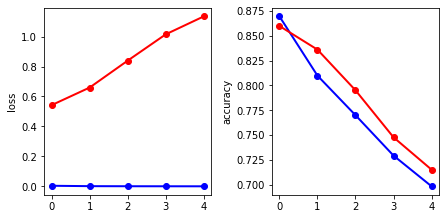

In [50]:
cm = 1/2.54
fig, axs = plt.subplots(1, 2, figsize=(16*cm, 8*cm))
axs[0].plot(history.history["loss"], 'bo-', lw=2, label="training")
axs[0].plot(history.history["val_loss"], 'ro-', lw=2, label="validation")
axs[0].set_ylabel("loss")
axs[1].plot(history.history["categorical_accuracy"], 'bo-', lw=2, label="training")
axs[1].plot(history.history["val_categorical_accuracy"], 'ro-', lw=2, label="validation")
axs[1].set_ylabel("accuracy")
plt.tight_layout()
plt.show()

In [51]:
predictions = tcn_model.predict(val_data)

In [52]:
predictions.shape

(714, 400, 3)

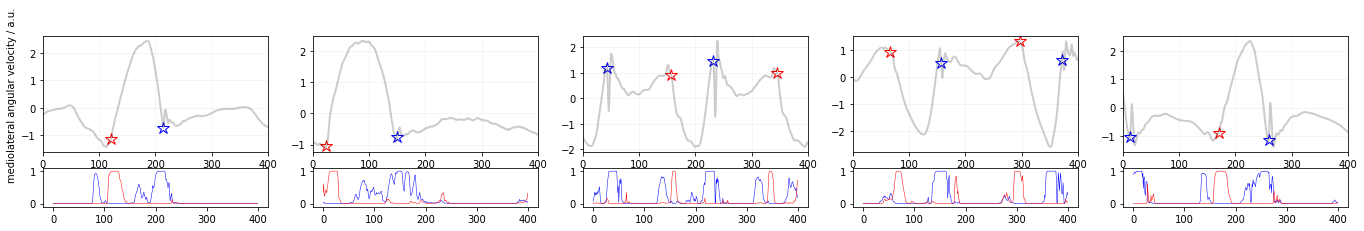

In [54]:
num_examples = 5
indx_random = np.random.choice(val_data.shape[0], num_examples, replace=False)
cm = 1/2.54
fig, axs = plt.subplots(2, num_examples, figsize=(2*29.7*cm, 8*cm), gridspec_kw={'height_ratios': [3, 1]})
for (i, indx) in enumerate(indx_random):
    if CLASSIFICATION_TASK == "events":
        axs[0][i].plot(np.argwhere(val_targets[indx][:,0]==2)[:,0], val_data[indx][np.argwhere(val_targets[indx][:,0]==2)[:,0],5], ls="none", marker="*", mfc="none", mec="r", ms=12)
        axs[0][i].plot(np.argwhere(val_targets[indx][:,0]==1)[:,0], val_data[indx][np.argwhere(val_targets[indx][:,0]==1)[:,0],5], ls="none", marker="*", mfc="none", mec="b", ms=12)
        axs[1][i].plot(predictions[indx][:,1], ls="-", c=(0, 0, 1), lw=0.5)
        axs[1][i].plot(predictions[indx][:,2], ls="-", c=(1, 0, 0), lw=0.5)
        axs[1][i].set_ylim((-0.1, 1.1))
        axs[1][i].set_yticks((0., 1.))
    else:
        axs[0][i].fill_between(np.arange(val_labels[indx].shape[0]), val_labels[indx][:,0]*max(val_data[indx][:,5]), color=(0, 1, 0), alpha=0.1, edgecolor='none')
        axs[0][i].fill_between(np.arange(val_labels[indx].shape[0]), val_labels[indx][:,0]*min(val_data[indx][:,5]), color=(0, 1, 0), alpha=0.1, edgecolor='none')
    axs[0][i].plot(val_data[indx][:,5], color=(0, 0, 0), alpha=0.2, lw=2)
    axs[0][i].grid(True, which="minor", ls=":", color=(0, 0, 0), alpha=0.05)
    axs[0][i].grid(True, which="major", color=(0, 0, 0), alpha=0.05)
    axs[0][i].set_xlim((0, val_data[indx].shape[0]))
axs[0][0].set_ylabel("mediolateral angular velocity / a.u.")
axs[0][num_examples//2].set_xlabel("time / samples")
plt.show()

In [40]:
predictions[indx_random[0]]

array([[9.9700350e-01, 2.4637191e-03, 5.3277245e-04],
       [9.9856228e-01, 1.2701905e-03, 1.6759234e-04],
       [9.9928635e-01, 6.1237055e-04, 1.0123177e-04],
       ...,
       [9.9978012e-01, 1.3656160e-04, 8.3353545e-05],
       [9.9997759e-01, 9.2499422e-06, 1.3073714e-05],
       [9.9999046e-01, 1.8917899e-06, 7.5819971e-06]], dtype=float32)